# Qafar-af Speech Command Recognition: Recognizing keywords

This Notebook demonstrates the preprocess audio files in the WAV format and build and train a basic [automatic speech recognition](https://en.wikipedia.org/wiki/Speech_recognition) (ASR) model for recognizing five different words in Qafar-af Language. The dataset is collected and processed which contains short (one-second or less) audio clips of commands, such as "Qembis", "Derreh", "Gurra", "Migda", "Solis", "Noise" and "unknown".

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/Mubarekethio/Voice-Recognition-Qafaraf-and-Amharic-">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    GitHub Link</a>
  </td>
  <td>
    <a target="_blank" href="https://www.linkedin.com/in/mubarek-kebede-582012148">
    <img src="https://content.linkedin.com/content/dam/me/business/en-us/amp/brand-site/v2/bg/LI-Bug.svg.original.svg" width="40" height="40" />
    Linkdin</a>
  </td>
  <td>
    <a target="_blank" href="https://x.com/mubarekethio">
    <img src="https://help.twitter.com/content/dam/help-twitter/brand/logo.png" width="40" height="40"/>
    Twitter</a>
  </td>
  
  <td>
    <a href="https://drive.google.com/drive/folders/1ztXhMlpbRliUlhhkVw--uLETXYj3yQSN"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Retrain a speech recognition model with TensorFlow Lite Model Maker for QSCR
This notebook is used a transfer learning approach on a previosly traind model to use for Qafaraf speech recognition model

## Import the required packages

TensorFlow, TFLite Model Maker, and some modules for audio manipulation, playback, and visualizations is needed then download and import the package that needed for this notebook.

#!python --version Python 3.8.10 #mu_envlite3.8 python enviroment

In [2]:
#!sudo apt -y install libportaudio2
# pip install tflite-model-maker

import os
import glob
import random
import shutil

import librosa
import soundfile as sf
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
from tflite_model_maker.config import ExportFormat
from timeit import default_timer as timer

from tflite_support import metadata
import json

#!python --version Python 3.8.10 #mu_envlite3.8 python enviroment
!python --version

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

c:\Users\Mu_keeS\#prSpMM\.mu_envlite3.8\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Python 3.8.10
TensorFlow Version: 2.5.0
Model Maker Version: 0.3.2


## Prepare the dataset


To train with QSCR speech dataset  following steps are followed:

**Note:**
The retrain model that uses in this notebook expects input data to be roughly one second of audio at 44.1 kHz. Model Maker perfoms automatic resampling for the training dataset, so there's no need to resample the QSCR dataset from 16KHz to 44.1 kHz. But the audio sample must be one second long, becuase audio samples longer than one second will be split into multiple one-second chunks, and the final chunk will be discarded if it's shorter than one second.

1. All sample in the dataset must be in  **WAV file format, about one second long**.
2. Then create audio dataset file with all of the WAV files,
3. Organized into separate subfolders for each classification. For example, each sample for a speech command "Qembis" should be in a subfolder named "Qembis".
4. The dataset can be splited into train/validation/test datasets either manually or automatically.

For Speech recognition task good set of background noises are needed to give the trained model the ability of distinguish speech from other noises (including silence). so the Qafar-af speech command dataset have seven classes. it's the five speech command that used as a keyword and the unknown and background noise classes. 
(i.e.. Derreh, Gurra, Migda, Qembis, Solis, Unknown and background)

#### Preparing the Background Noise Dataset
A good set of background noises are avialiable in the internet dowloading and preparing it with some other sample of noises that is recorded in my own. The background noises is collected in one minute long WAV format then it must be split into smaller one-second samples. there also a huge number of audios availiable to use as a background noise to download the following code can be used

In [ ]:
#To download best background noise and silence audio file

#tf.keras.utils.get_file('background_audio.zip',
                        'https://storage.googleapis.com/download.tensorflow.org/models/tflite/sound_classification/background_audio.zip',
                        cache_dir='./',
                        cache_subdir='dataset-background',
                        extract=True)

In [ ]:
# Create a list of all the background wav files
#files = glob.glob(os.path.join('./dataset-speech/_background_noise_', '*.wav'))
#files = files + glob.glob(os.path.join('./dataset-background', '*.wav'))
'''
files = glob.glob(os.path.join('../_V_Data/v_QF_MM/_background_noise_', '*.wav'))
files = files + glob.glob(os.path.join('../_V_Data/v_QF_MM/background_audio', '*.wav'))

background_dir = '../_V_Data/v_QF_MM/background'
os.makedirs(background_dir, exist_ok=True)

# Loop through all files and split each into several one-second wav files
for file in files:
    filename = os.path.basename(os.path.normpath(file))
    print('Splitting', filename)
    name = os.path.splitext(filename)[0]
    rate = librosa.get_samplerate(file)
    length = round(librosa.get_duration(filename=file))
    for i in range(length - 1):
        start = i * rate
        stop = (i * rate) + rate
        data, _ = sf.read(file, start=start, stop=stop)
        sf.write(os.path.join(background_dir, name + str(i) + '.wav'), data, rate)
        
'''

### Importing and Splitting the Dataset into test and train data 
After changing the filename and path name above, the model is ready to train with dataset. dataset must be splited in to train/test and validation dataset.
this notebook used two method for spliting the dataset from the main directories
1. Using automatic split the data set in python code 
2. Using the manual method by organizing the dataset into validation/test/train data set

### Splitting Using Python code

In [ ]:
# (this path contains all the subfolders with classification names):
#dataset_dir = '../_V_Data/v_QF_MM/data_v2'

'''
def move_background_dataset(dataset_dir):
  dest_dir = os.path.join(dataset_dir, 'background')
  if os.path.exists(dest_dir):
    files = glob.glob(os.path.join(background_dir, '*.wav'))
    for file in files:
      shutil.move(file, dest_dir)
  else:
    shutil.move(background_dir, dest_dir)
'''

In [ ]:
# Move background samples into custom dataset
'''
move_background_dataset(dataset_dir)

# Now we separate some of the files that we'll use for testing:
test_dir = '../_V_Data/v_QF_MM/dataset-test'
test_data_ratio = 0.2
dirs = glob.glob(os.path.join(dataset_dir, '*/'))
for dir in dirs:
    files = glob.glob(os.path.join(dir, '*.wav'))
    test_count = round(len(files) * test_data_ratio)
    random.seed(42)
    random.shuffle(files)
    # Move test samples:
    for file in files[:test_count]:
        class_dir = os.path.basename(os.path.normpath(dir))
        os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)
        os.rename(file, os.path.join(test_dir, class_dir, os.path.basename(file)))
    print('Moved', test_count, 'images from', class_dir)
    
'''

### Import the Splitted Audio datasset

In [2]:
### Import the Splitted Audio datasset
val_dir = '../_V_Data/splitted_QF/Val_MM'
test_dir = '../_V_Data/splitted_QF/Test_MM'
train_dir= '../_V_Data/splitted_QF/Train_MM'

### Play a sample
To be sure the dataset looks correct, let's play at a random sample from the test set:

In [27]:
def get_random_audio_file(samples_dir):
    files = os.path.abspath(os.path.join(samples_dir, '*/*.wav'))
    files_list = glob.glob(files)
    random_audio_path = random.choice(files_list)
    return random_audio_path

def show_sample(audio_path, plot_number):
    audio_data, sample_rate = sf.read(audio_path)
    class_name = os.path.basename(os.path.dirname(audio_path))
    print(f'Class: {class_name}')
    #print(f'File: {audio_path}')
    print(f'Sample rate: {sample_rate}')
    print(f'Sample length: {len(audio_data)}')

    plt.figure(plot_number, figsize=(4,3))
    plt.title(f'{class_name} - Sample {plot_number}')
    plt.plot(audio_data)
    plt.show()
    display(Audio(audio_data, rate=sample_rate))


Class: Derreh
Sample rate: 16000
Sample length: 16000


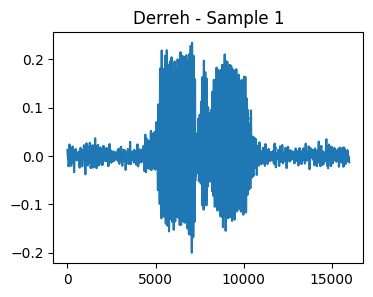

Class: Migda
Sample rate: 16000
Sample length: 16000


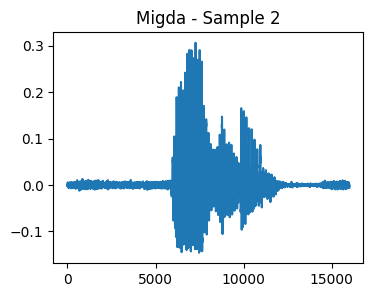

Class: Qembis
Sample rate: 16000
Sample length: 16000


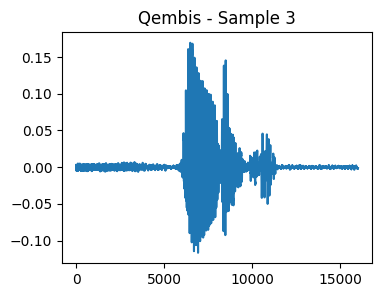

In [17]:
# Assuming the same for loop to display 3 random audio samples
for i in range(3):
    random_audio = get_random_audio_file(test_dir)
    show_sample(random_audio, i+1)  # Pass plot number (1, 2, 3) to separate plots

## Define the model

When using Model Maker to retrain any model, it must be start by defining a model spec. The spec defines the base model from which the new model will extract feature embeddings to begin learning new classes. 
1. The spec for this speech recognizer is based on the pre-trained [BrowserFft model from TFJS](https://github.com/tensorflow/tfjs-models/tree/master/speech-commands#speech-command-recognizer).
2. The model expects input as an audio sample that's 44.1 kHz, and just under a second long: the exact sample length must be 44034 frames.
3. Model Maker also can resample the audio data that are note have a sampling rate of 44.1 khz but when using inference we must be take consideration that the input of the audio sample must matches with the expected format.
4. Then instatiate the model [`BrowserFftSpec`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/audio_classifier/BrowserFftSpec):

In [8]:
spec = audio_classifier.BrowserFftSpec()

INFO:tensorflow:Checkpoints are stored in C:\Users\Mu_keeS\AppData\Local\Temp\tmp8vqy9a7s


## Load your dataset 

Now you need to load your dataset according to the model specifications. Model Maker includes the [`DataLoader`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/audio_classifier/DataLoader) API, which will load your dataset from a folder and ensure it's in the expected format for the model spec.
1. The training and validation dataset is used to in the training process to train and validate the model during Training. if they are splitted and organized in the different folder you can load separatelly., else they can be splitted using the [`DataLoader`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/audio_classifier/DataLoader) API, function by passing  train_data_ratio = 0.8. the finally the test dataset is used to test the model performance.

**Note:** Setting `cache=True` is important to make training faster (especially when the dataset must be re-sampled) but it will also require more RAM to hold the data. If you use a very large custom dataset, caching might exceed your RAM capacity.

In [ ]:
#To Split the train validation data using Dataloader API
'''
train_data_ratio = 0.8

train_data = audio_classifier.DataLoader.from_folder(
    spec, dataset_dir, cache=True)

train_data, validation_data = train_data.split(
    train_data_ratio)
'''

### Import the Splitted Audio datasset

In [6]:
val_dir = '../_V_Data/splitted_QF/Val_MM'
print(f"VAl Directory{val_dir}")

test_dir = '../_V_Data/splitted_QF/Test_MM'
print(f"Test Directory{test_dir}")

train_dir= '../_V_Data/splitted_QF/Train_MM'
print(f"Train Directory{train_dir}")




VAl Directory../_V_Data/splitted_QF/Val_MM
Test Directory../_V_Data/splitted_QF/Test_MM
Train Directory../_V_Data/splitted_QF/Train_MM


In [9]:
#Load all train val and test data from the organized folder
train_data =audio_classifier.DataLoader.from_folder(
    spec, train_dir, cache=True)

validation_data = audio_classifier.DataLoader.from_folder(
    spec, val_dir, cache=True)

test_data = audio_classifier.DataLoader.from_folder(
    spec, test_dir, cache=True)

## Train the model

Now by using the Model Maker [`create()`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/audio_classifier/create) function to create a model based on the model spec and training dataset.
The batch_size and number of epochs is a parameter that can help to trigger the training with good performance 

**Note:** The first epoch takes longer because it must create the cache. 

In [14]:
# If your dataset has fewer than 100 samples per class,
# you might want to try a smaller batch size
batch_size = 25
epochs = 25
model= audio_classifier.create(train_data, spec, validation_data, batch_size=batch_size, epochs=epochs, train_whole_model=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 42, 225, 8)        136       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 112, 8)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 109, 32)       2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 51, 32)         8224      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 25, 32)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 22, 32)        

## Review the model performance

### Evaluate Model Performance
Even if the accuracy/loss looks good from the training output above, it's important to also run the model using test data that the model has not seen yet, which is what the `evaluate()` method does here:

In [15]:
eval= []
eval= model.evaluate(test_data)
print(f'Accuracy= {eval[1]*100}')
print(f'Loss= {eval[0]}')

28/28 [==============================] - 112s 4s/step - loss: 0.0298 - acc: 0.9922
Accuracy= 99.21700358390808
Loss= 0.029755692929029465


### View the confusion matrix

When training a classification model such as this one, it's also useful to inspect the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). The confusion matrix gives you detailed visual representation of how well your classifier performs for each classification in your test data.

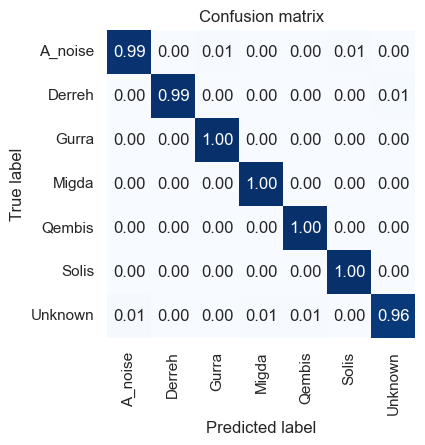

In [17]:
def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  sns.set(rc = {'figure.figsize':(6,4)})
  sns.heatmap(
      confusion_normalized, xticklabels=test_labels, yticklabels=test_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True, cbar=False)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

confusion_matrix = model.confusion_matrix(test_data)
show_confusion_matrix(confusion_matrix.numpy(), test_data.index_to_label)

In [16]:
model

## Test the Model with External audio

## Export the model

The last step is exporting the model into the TensorFlow Lite format for execution on mobile/embedded devices and into the [SavedModel format](https://www.tensorflow.org/guide/saved_model) for execution elsewhere.

When exporting a `.tflite` file from Model Maker, it includes [model metadata](https://www.tensorflow.org/lite/inference_with_metadata/overview) that describes various details that can later help during inference. It even includes a copy of the classification labels file, so you don't need to a separate `labels.txt` file. (In the next section, we show how to use this metadata to run an inference.)

In [22]:
TFLITE_FILENAME = 'Qf_mM_V700.tflite'
SAVE_PATH = '../Model/ModelMaker/Qf_MM700'

In [23]:
print(f'Exporing the model to {SAVE_PATH}')
model.export(SAVE_PATH, tflite_filename=TFLITE_FILENAME)
model.export(SAVE_PATH, export_format=[mm.ExportFormat.SAVED_MODEL, mm.ExportFormat.LABEL])

Exporing the model to ../Model/ModelMaker/Qf_MM700
INFO:tensorflow:Assets written to: C:\Users\Mu_keeS\AppData\Local\Temp\tmphs8bod2m\assets
INFO:tensorflow:TensorFlow Lite model exported successfully: ../Model/ModelMaker/Qf_MM700\Qf_mM_V700.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ../Model/ModelMaker/Qf_MM700\Qf_mM_V700.tflite


INFO:tensorflow:Assets written to: ../Model/ModelMaker/Qf_MM700\saved_model\assets


INFO:tensorflow:Assets written to: ../Model/ModelMaker/Qf_MM700\saved_model\assets


INFO:tensorflow:Saving labels in ../Model/ModelMaker/Qf_MM700\labels.txt


INFO:tensorflow:Saving labels in ../Model/ModelMaker/Qf_MM700\labels.txt


## Run inference with TF Lite model

Now your TFLite model can be deployed and run using any of the supported [inferencing libraries](https://www.tensorflow.org/lite/guide/inference) or with the new [TFLite AudioClassifier Task API](https://www.tensorflow.org/lite/inference_with_metadata/task_library/audio_classifier). The following code shows how you can run inference with the `.tflite` model in Python.

In [28]:
# This library provides the TFLite metadata API
# pip install -q tflite_support

def get_labels(model):
  """Returns a list of labels, extracted from the model metadata."""
  displayer = metadata.MetadataDisplayer.with_model_file(model)
  labels_file = displayer.get_packed_associated_file_list()[0]
  labels = displayer.get_associated_file_buffer(labels_file).decode()
  return [line for line in labels.split('\n')]

def get_input_sample_rate(model):
  """Returns the model's expected sample rate, from the model metadata."""
  displayer = metadata.MetadataDisplayer.with_model_file(model)
  metadata_json = json.loads(displayer.get_metadata_json())
  input_tensor_metadata = metadata_json['subgraph_metadata'][0][
          'input_tensor_metadata'][0]
  input_content_props = input_tensor_metadata['content']['content_properties']
  return input_content_props['sample_rate']

To observe how well the model performs with real samples, run the following code block over and over. Each time, it will fetch a new test sample and run inference with it, and you can listen to the audio sample below.

In [100]:
def plot_bar(audio_data, output_data, labels):
    # Display prediction and ground truth
    top_index = np.argmax(output_data[0])
    label = labels[top_index]
    score = output_data[0][top_index]

    indices = range(len(labels))
    #Print predicted and truth class of the test audio
    #print('---prediction---')
    #print(f'Class: {label}\nScore: {score}')
    #print('----truth----')

    #play the truth audio data 
    #audio_data, sample_r = sf.read(random_audio)
    #print(f'Sample rate: {sample_r}')
    #print(f'Sample length: {len(audio_data)}')
    #plt.plot(audio_data)
    #display(Audio(audio_data, rate=sample_r))


    #plot the result in bar graph
    plt.figure(figsize=(5, 2))
    plt.bar(labels, output_data[0])
    plt.xticks(indices, labels, rotation=45)
    plt.title(label)
    plt.show()

In [102]:
def run_inferences(audio, tflit_model):
    st = timer()
    label = get_labels(tflit_model)
    # Ensure the audio sample fits the model input
    interpreter = tf.lite.Interpreter(tflite_file)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    input_size = input_details[0]['shape'][1]
    sample_rate = get_input_sample_rate(tflite_file)

    audio_data, _ = librosa.load(audio, sr=sample_rate)
    if len(audio_data) < input_size:
        audio_data.resize(input_size)
    audio_data = np.expand_dims(audio_data[:input_size], axis=0)

    #Play the Audio
    display(Audio(audio_data, rate=sample_rate))

    # Run inference
    interpreter.allocate_tensors()
    interpreter.set_tensor(input_details[0]['index'], audio_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    end= timer()
    #print(f'Inference time: {end-st}')

    plot_bar(audio_data, output_data,label)

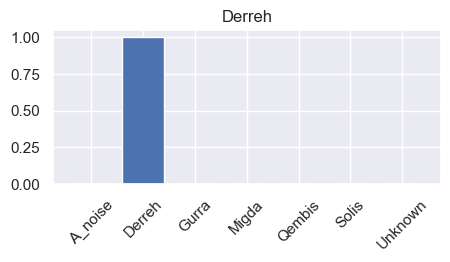

In [108]:
# Get a WAV file for inference and list of labels from the model
tflite_file = os.path.join(SAVE_PATH, TFLITE_FILENAME)
random_audio = get_random_audio_file(test_dir)

run_inferences(random_audio, tflite_file)


In [58]:
labels

['A_noise', 'Derreh', 'Gurra', 'Migda', 'Qembis', 'Solis', 'Unknown']

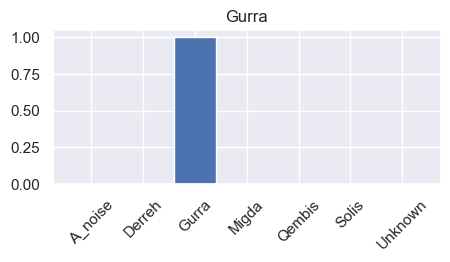

In [109]:
tflite_file = "../Model/ModelMaker/Qf_MM100/Qf_mM_V100.tflite" #
#tflite_file = os.path.join(SAVE_PATH, TFLITE_FILENAME)

random_audio= "../_V_Data/Qf_For_test/Afar-afe_test5.wav"
run_inferences(random_audio, tflite_file)

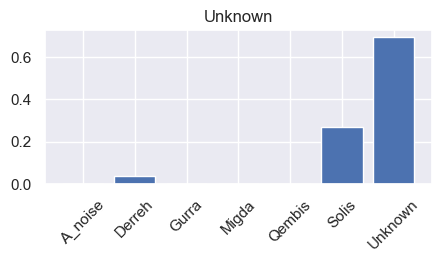

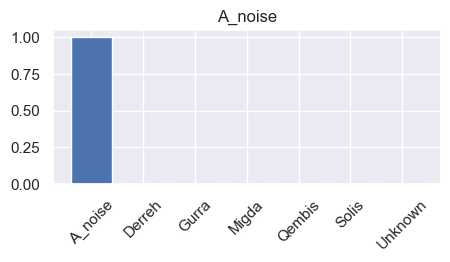

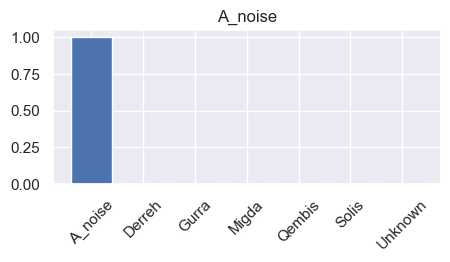

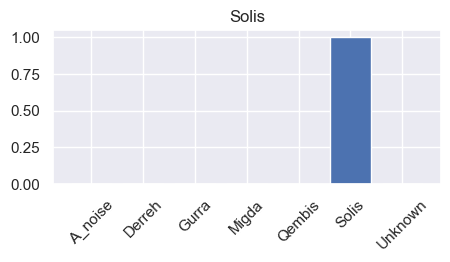

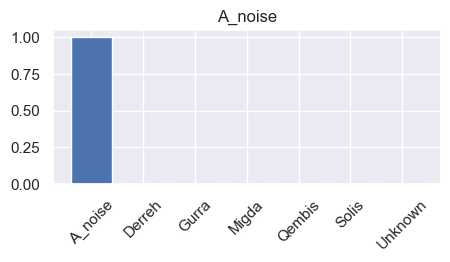

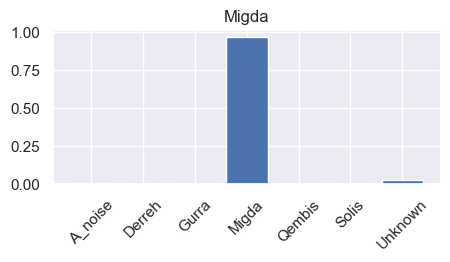

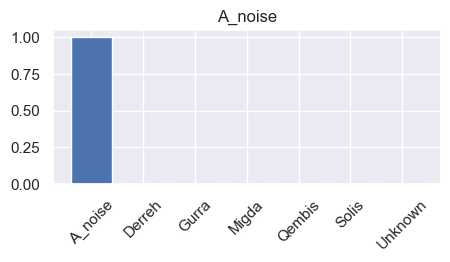

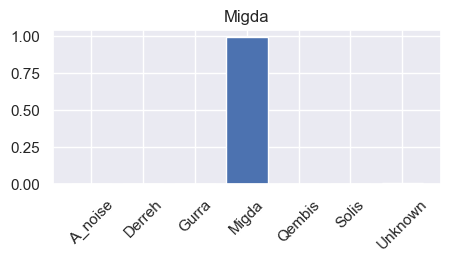

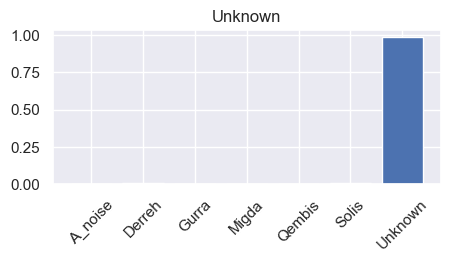

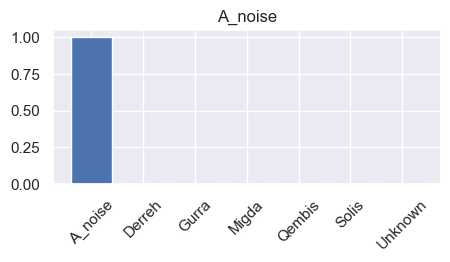

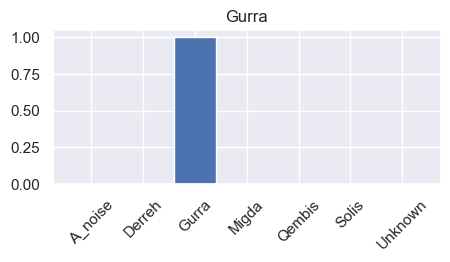

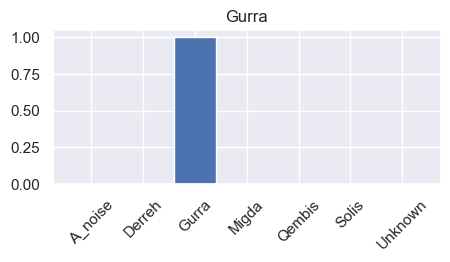

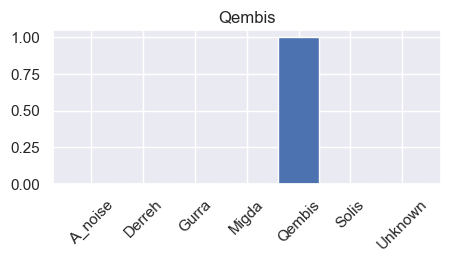

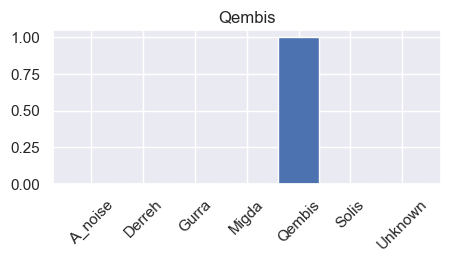

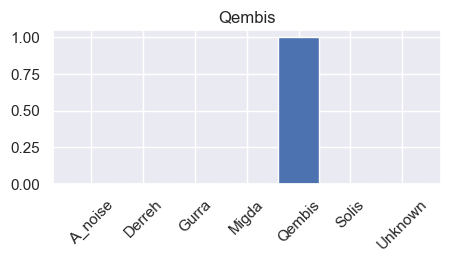

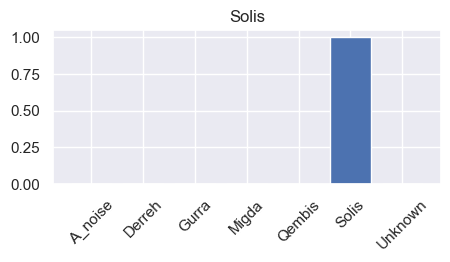

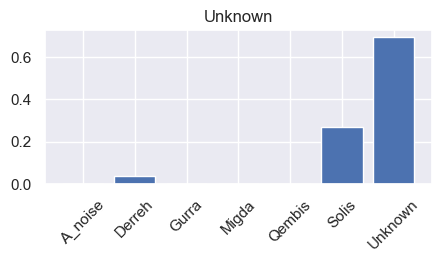

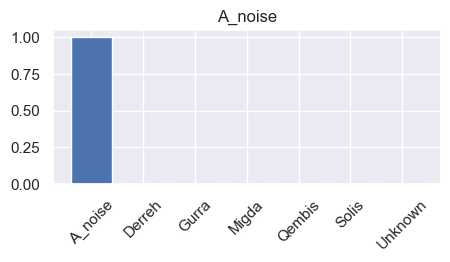

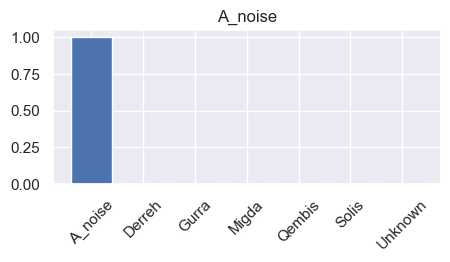

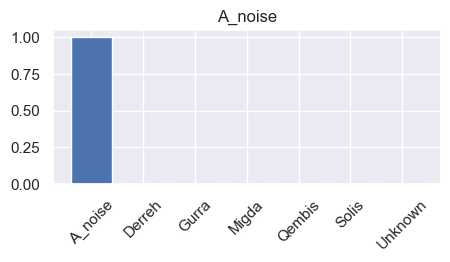

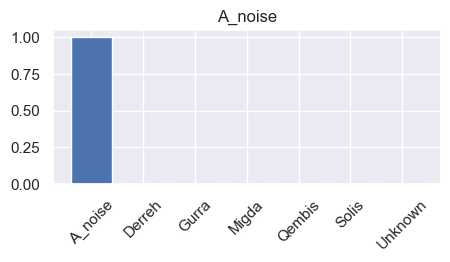

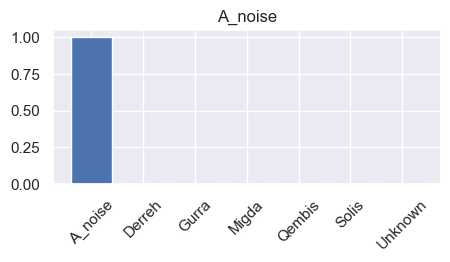

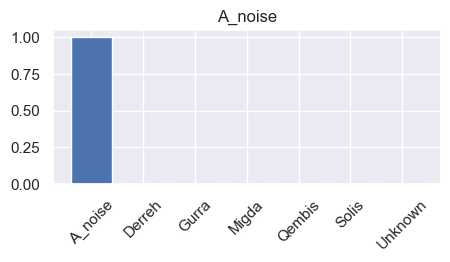

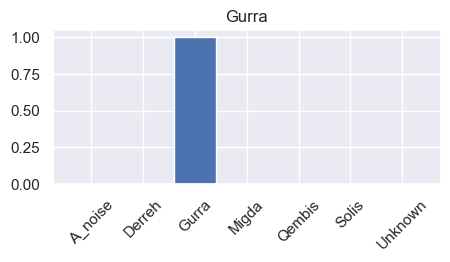

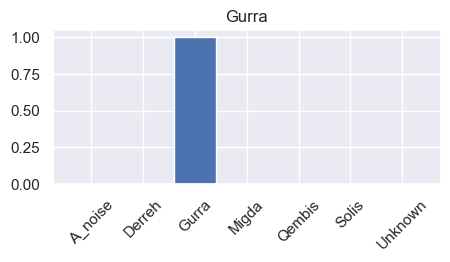

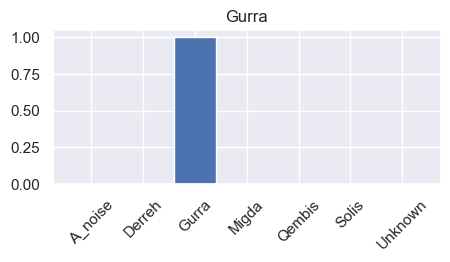

In [110]:
# Directory containing folders for each class
tflite_file = "../Model/ModelMaker/Qf_MM700/Qf_mM_V700.tflite"


test_a= "../_V_Data/Qf_For_test"#/splitted_QF/Train_MM"
test_d = os.listdir(test_a)
for audio in test_d:
    sampl = os.path.join(test_a, audio)
    run_inferences(sampl, tflite_file)
    #print(sampl)


Import the model and test inference using random audio from the audio data availiable in the pc

## Finally 
Check out our end-to-end example apps that perform inferencing with TFLite audio models on [Android](https://github.com/tensorflow/examples/tree/master/lite/examples/sound_classification/android/) and [iOS](https://github.com/tensorflow/examples/tree/master/lite/examples/sound_classification/ios).